# **Simulazioni MD con il modulo CMS: SteepestDescent**

---

> ⚠️ Attualmente implementato soltanto per cristalli di argento (Ag) con potenziale di Lennard-Jones.

## Cosa fa l'algoritmo di _steepest descent_?

In una simulazione di minamica molecolare, le posizioni iniziali degli atomi, nel nostro caso caricate da un file esterno, potrebbero non corrispondere a una configurazione fisica possibile (e.g. N atomi nello stesso punto). Sovrapposizioni di questo tipo possono generare forze enormi che farebbero "esplodere" la simulazione. L'algoritmo di _steepest descent_ permette di ricostruire una configurazione di equilibrio in cui $\vec{F}(k) = 0, \forall k \iff -\vec{\nabla} V = 0$, cioè un minimo dell'energia potenziale.\

In una configurazione generica, come quella in [fcc100a256.txt](../../../data/pos-fcc100-random/fcc100a256.txt), gli atomi sono soggetti a forze non nulle. Queste sono sempre opposte in verso al gradiente del potenziale, perciò 'spingono' gli atomi nella direzione del minimo dell'energia più vicino.

<img src="../images/3-SteepestDescent/potential-not-minima.png" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: 5px; width: 400px;">

Ad esempio, nell'immagine una particella in posizione $\vec{r}_k$ è soggetta ad una forza $\vec{F}_k$, tanto maggiore quanto più ripida è la superficie del poteziale. L'idea dell'algoritmo è spostare la particella $k$ di una quantità $\delta\vec{r}_k$ proporzionale alla forza $\vec{F}_k$, quindi ricalcolare l'intero profilo di potenziale. Questo processo viene ripetuto più volte finché non si raggiunge il minimo locale.

---

## Costruire un oggetto `SteepestDescent`

L'oggetto `SteepestDescent` di `CMS` contiene la logica dell'algoritmo di _discesa più ripida_. Per essere istanzato, richiede un oggetto `CrystalStructure` da manipolare. In questo caso, si costruisce un cristallo usando le coordinate in [fcc100a256.txt](../../../data/pos-fcc100-random/fcc100a256.txt).

In [1]:
from CMS.MolecularDynamics.CrystalStructure import CrystalStructure
nomefile = "../../../data/pos-fcc100-random/fcc100a256.txt"
cristallo = CrystalStructure.from_file(nomefile)

from CMS.MolecularDynamics.SteepestDescent import SteepestDescent
algoritmo_sd = SteepestDescent(crystal=cristallo)

L'algoritmo viene lanciato dal metodo `.minimize_energy()`, che accetta i seguenti parametri:

<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`max_steps`** | int | 1000 | Numero massimo di step che effettua l'algoritmo |
| **`F_tol`** | float | 0.00001 | Massima forza possibile che interrompe l'algoritmo |
| **`C_steep`** | float | 0.01 | Costante di proporzionalità che quantifica lo spostamento |
| **`pol_junction`** | bool | False | Se usare o meno la giunzione polinomiale nel potenziale |
</div>

In ogni step, da `0` a `max_steps-1`, l'algoritmo produce internamente un oggetto `CrystalPotential` e valuta energia potenziale e forze con i metodi descritti in [2-CrystalPotential](2-CrystalPotential.ipynb). In due liste, andrà a raccogliere:
* `potential_energies_list`: l'attuale valore dell'energia potenziale
* `max_forces_list`: l'attuale forza massima, intesa come massima norma dei vettori forza:  $\max(\{||\vec{F}_k||\}_{k=0,...,N-1})$

Successivamente, si valuta il **criterio di convergenza**, ovvero si controlla se la forza massima è inferiore a `F_tol`: in quel caso, si considera raggiunto in maniera sufficientemente vicina il minimo locale e l'algoritmo si interrompe. Se la condizione `max_force < F_tol` non è verificata, l'algoritmo prosegue andando a modificare la posizione di ciascun atomo di una quantità $\delta\vec{r}_k = C_{steep}\vec{F}_k$. Quindi si passa allo step successivo. 

Se la procedura termina dopo `max_steps`, il **criterio di convergenza** non è stato raggiunto.

> ↪️ il metodo `.minimize_energy()` restituisce le liste `potential_energies_list` e `max_forces_list`; inoltre, stampa a schermo il numero di step eseguiti e se si è verificata o meno la convergenza.

In [2]:
# Eseguo la minimizzazione steepest descent utilizzando un potenziale con giunzione polinomiale
potential_energies, max_forces = algoritmo_sd.minimize_energy(
    max_steps = 1000,
    F_tol = 0.00001,
    C_steep = 0.01,
    pol_junction=False, # non serve, perché R_C non è impostato: tutti gli atomi sono 'vicini'
)

Converged in 638 steps.


> ‼️ le coordinate atomiche sono modificate direttamente nell'attributo `CrystalStructure` in `SteepestDescent.crystal`

Le posizioni finali post-minimizzazione possono essere salvate con facilità nello stesso formato delle posizioni iniziali, è sufficiente usare `np.savetxt`:

In [3]:
import numpy as np
np.savetxt(f'../tutorials_outputs/fcc100a256_minimizzate.txt', algoritmo_sd.crystal.positions)

---

## Esempio di utilizzo

Proviamo a giocare con i parametri dell'algoritmo, ad esempio modificando `C_steep`. Per eseguire più volte SD a partire dalla medesima configurazione iniziale, occorre creare ex-novo un oggetto CrystalStructure ogni volta; in questo caso non siamo interessati a salvare le posizioni, vogliamo solo osservare il comportamento dell'energia potenziale e della forza massima durante la minimizzazione.

In [15]:
# lista di C da provare
C_steep_list = [0.1, 0.01, 0.001, 0.0005]
max_steps = 1000
F_tol = 0.00001
# dizionario per salvare le liste di energie e forze massime per ogni C
register = {}

for C_steep in C_steep_list:
    # creo un nuovo cristallo da file per ogni C, per partire sempre dalla stessa configurazione iniziale
    cristallo = CrystalStructure.from_file(nomefile)
    # istanzio un nuovo oggetto SteepestDescent
    algoritmo_sd = SteepestDescent(crystal=cristallo)
    # creo un nuovo campo del dizionario register
    register[C_steep] = {}
    
    potential_energies, max_forces = algoritmo_sd.minimize_energy(
        max_steps = max_steps,
        F_tol = F_tol,
        C_steep = C_steep,
        pol_junction=False
    )
    register[C_steep]['potential_energies'] = potential_energies
    register[C_steep]['max_forces'] = max_forces

Maximum number of steps reached without convergence.
Converged in 638 steps.
Maximum number of steps reached without convergence.
Maximum number of steps reached without convergence.


I risultati osservati saranno:
* $C$ = 0.1) Maximum number of steps reached without convergence;
* $C$ = 0.01) Converged in 638 steps;
* $C$ = 0.001) Maximum number of steps reached without convergence;
* $C$ = 0.0005) Maximum number of steps reached without convergence.

L'immagine suggerisce questi commenti ai comportamenti osservati:

- $C$ = 0.1 è troppo grande: la configurazione salta avanti e indietro attorno a un minimo senza poterlo mai raggiungere;
- $C$ = 0.01 è una buona scelta: il sistema converge in meno di 700 steps;
- $C$ = 0.001 $\land$ 0.0005 sono troppo piccoli: gli spostamenti sono molto contenuti e 1000 step non sono sufficienti a raggiungere la convergenza.  

<img src="../images/3-SteepestDescent/C-choice.png" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: 5px; width: 500px;">

Se così fosse, aumentare il numero massimo di step potrebbe far convergere i $C$ più piccoli, senza cambiare invece l'esito su quello più grande. Proviamo:

In [6]:
# cambio il numero massimo di steps
max_steps = 10_000

# resetto il dizionario
register = {}

for C_steep in C_steep_list:
    # creo un nuovo cristallo da file per ogni C, per partire sempre dalla stessa configurazione iniziale
    cristallo = CrystalStructure.from_file(nomefile)
    # istanzio un nuovo oggetto SteepestDescent
    algoritmo_sd = SteepestDescent(crystal=cristallo)
    # creo un nuovo campo del dizionario register
    register[C_steep] = {}
    
    potential_energies, max_forces = algoritmo_sd.minimize_energy(
        max_steps = max_steps,
        F_tol = F_tol,
        C_steep = C_steep,
        pol_junction=False
    )
    register[C_steep]['potential_energies'] = potential_energies
    register[C_steep]['max_forces'] = max_forces

Maximum number of steps reached without convergence.
Converged in 638 steps.
Converged in 6426 steps.
Maximum number of steps reached without convergence.


Ecco mostrato che, aumentando il numero di step massimi, il sistema arriva a convergenza anche con $C$ più piccoli, per $C=0.0001$ però 10mila step non sono ancora sufficienti. Per quanto riguarda $C=0.1$, potrebbe soddisfare la condizione di convergenza soltanto aumentando `F_tol`; l'idea di un algoritmo di minimizzazione come SD però è raggiungere una precisione sufficiente impiegando poco tempo: ~6500 step per $C=0.001$ impiegano una manciata di secondi, per cui non vale la pena di diminuire ulteriormente la precisione.

Vediamo quanti step servono a $C=0.0005$:

In [16]:
# stavolta ignoriamo C=0.1
C_steep_list = [0.01, 0.001, 0.0005]

# cambio il numero massimo di steps
max_steps = 50_000

# resetto il dizionario
register = {}

for C_steep in C_steep_list:
    # creo un nuovo cristallo da file per ogni C, per partire sempre dalla stessa configurazione iniziale
    cristallo = CrystalStructure.from_file(nomefile)
    # istanzio un nuovo oggetto SteepestDescent
    algoritmo_sd = SteepestDescent(crystal=cristallo)
    # creo un nuovo campo del dizionario register
    register[C_steep] = {}
    
    potential_energies, max_forces = algoritmo_sd.minimize_energy(
        max_steps = max_steps,
        F_tol = F_tol,
        C_steep = C_steep,
        pol_junction=False
    )
    register[C_steep]['potential_energies'] = potential_energies
    register[C_steep]['max_forces'] = max_forces

Converged in 638 steps.
Converged in 6426 steps.
Converged in 12856 steps.


Notare che l'esecuzione dell'algoritmo s'interrompe autonomamente al raggiungimento della convergenza, non usa tutti i 50mila step a sua disposizione! Proviamo a vedere cosa cambia tra le diverse minimizzazioni, producendo un grafico dell'energia potenziale in funzione del numero di step, e uno della forza massima in funzione del numero di step.

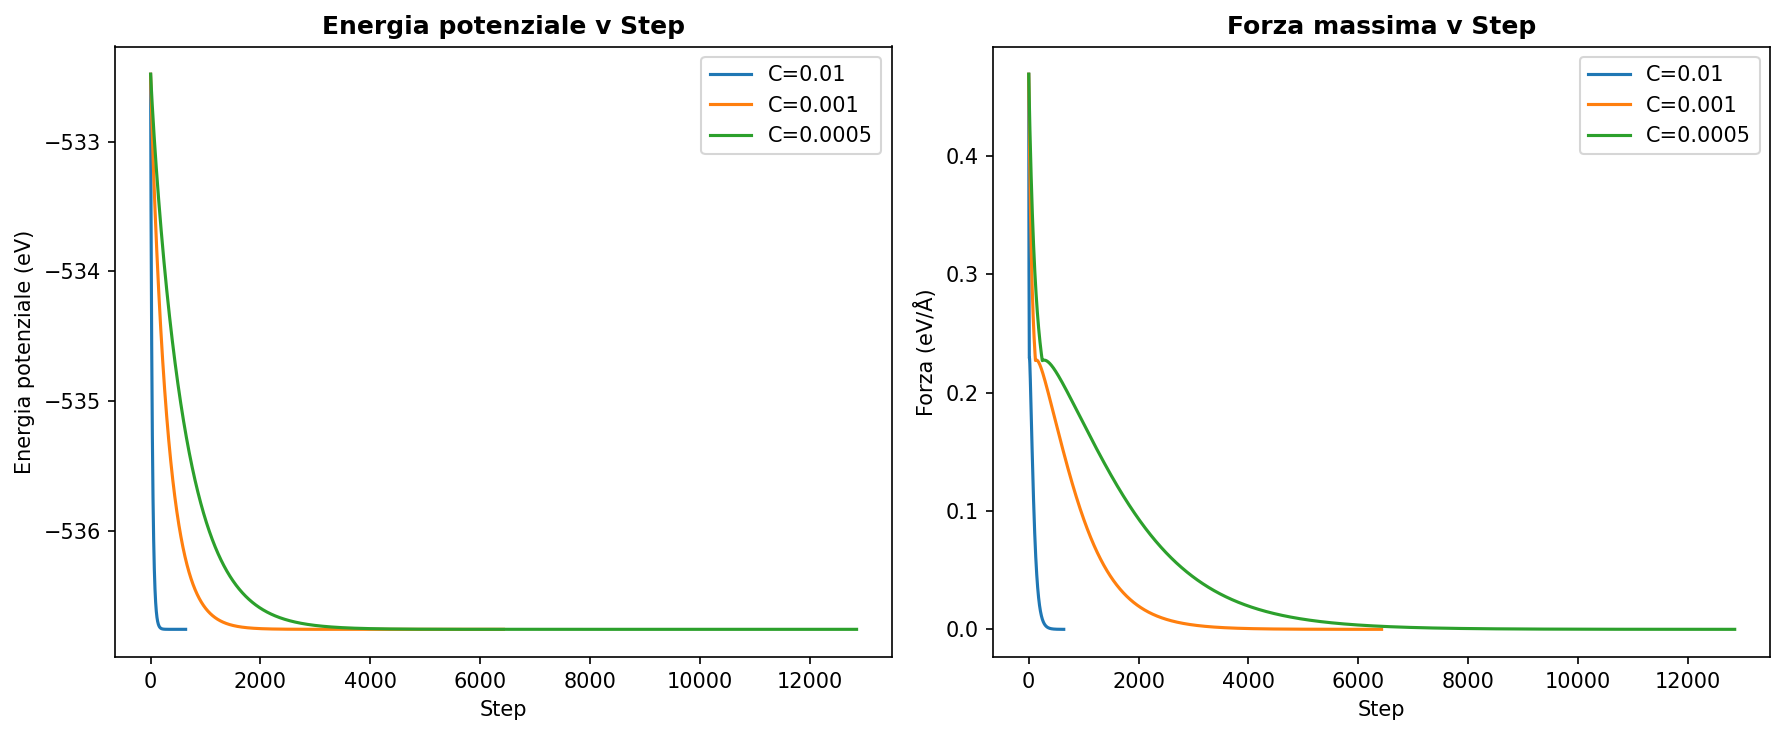

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

for C_steep in C_steep_list:
    ax[0].plot(register[C_steep]['potential_energies'], label=f"C={C_steep}")
    ax[1].plot(register[C_steep]['max_forces'], label=f"C={C_steep}")

ax[0].set_title("Energia potenziale v Step", fontweight='bold')
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Energia potenziale (eV)")
ax[0].legend()

ax[1].set_title("Forza massima v Step", fontweight='bold')
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Forza (eV/Å)")
ax[1].legend()

plt.tight_layout()
plt.show()

L'energia è **monotona decrescente**, come ci si aspetta da un algoritmo di minimizzazione dell'energia. La forza invece ha un incremento locale, ma è possibile poiché la forza massima non è una variabile globale: può succedere che un singolo atomo veda un aumento temporaneo della forza a cui è soggetto.